First, we import the packages we will use

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, expr
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

Initialize the spark session

In [2]:
spark = SparkSession.builder \
    .appName("YouTube Viral Analysis") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()
print("✅ Spark session initialized.")

✅ Spark session initialized.


The csv file is large, so we use google drive to upload

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Read the whole dataset, and it has about 3 million records

In [3]:
file_path = '/content/drive/MyDrive/youtube_trending_videos_global.csv'
df = spark.read.option("header", "true").csv(file_path, inferSchema=True, multiLine=True, escape='"') # Execute in 4m
print(f"✅ Dataset loaded. Total records: {df.count()}")

✅ Dataset loaded. Total records: 2944549


The dataset has 28 columns

In [ ]:
df.printSchema()
df.show(100)

root
 |-- video_id: string (nullable = true)
 |-- video_published_at: string (nullable = true)
 |-- video_trending__date: string (nullable = true)
 |-- video_trending_country: string (nullable = true)
 |-- channel_id: string (nullable = true)
 |-- video_title: string (nullable = true)
 |-- video_description: string (nullable = true)
 |-- video_default_thumbnail: string (nullable = true)
 |-- video_category_id: string (nullable = true)
 |-- video_tags: string (nullable = true)
 |-- video_duration: string (nullable = true)
 |-- video_dimension: double (nullable = true)
 |-- video_definition: string (nullable = true)
 |-- video_licensed_content: boolean (nullable = true)
 |-- video_view_count: double (nullable = true)
 |-- video_like_count: double (nullable = true)
 |-- video_comment_count: double (nullable = true)
 |-- channel_title: string (nullable = true)
 |-- channel_description: string (nullable = true)
 |-- channel_custom_url: string (nullable = true)
 |-- channel_published_at: tim

Select some important columns to show

In [ ]:
df = df.select(
    "video_id", "video_title", "video_category_id", "video_view_count", "video_like_count", "video_comment_count"
).dropna(subset=["video_view_count", "video_like_count", "video_comment_count", "video_category_id"])

df = df.withColumn("video_view_count", col("video_view_count").cast("long")) \
       .withColumn("video_like_count", col("video_like_count").cast("long")) \
       .withColumn("video_comment_count", col("video_comment_count").cast("long")) \
       .withColumn("video_category_id", col("video_category_id").cast("int"))

df.show(5)

+-----------+--------------------+-----------------+----------------+----------------+-------------------+
|   video_id|         video_title|video_category_id|video_view_count|video_like_count|video_comment_count|
+-----------+--------------------+-----------------+----------------+----------------+-------------------+
|bB3-CUMERIU|JENNIE - Mantra (...|             NULL|        20535235|         2042255|             152933|
|zfb0whgBBA8|تحدي الحقيبة مع ا...|             NULL|          853167|          101155|              10541|
|UVb6QOKy0bI|Bougainvillea Tra...|             NULL|         1730189|           67522|               2869|
|IINqHUM71Xo|الفيديو التشويقي ...|             NULL|         1073421|           35534|               1263|
|6YMY62tMLUA|Bhool Bhulaiyaa 3...|             NULL|        56032799|         1058450|              44767|
+-----------+--------------------+-----------------+----------------+----------------+-------------------+
only showing top 5 rows



We use pandas and matplotlib to show some distributions

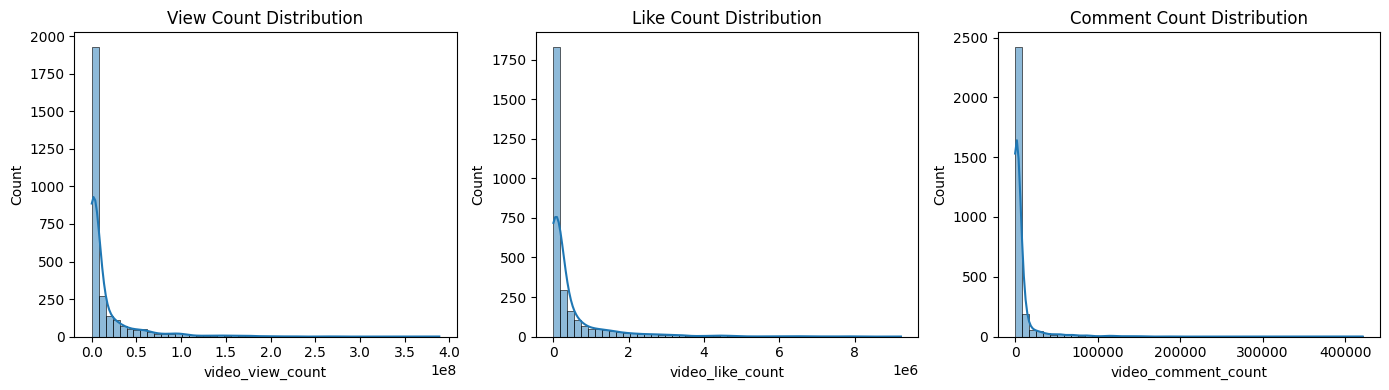

In [ ]:
stats_pd = df.select("video_view_count", "video_like_count", "video_comment_count").sample(fraction=0.001).toPandas()

plt.figure(figsize=(14,4))
plt.subplot(1,3,1)
sns.histplot(stats_pd["video_view_count"], bins=50, kde=True)
plt.title("View Count Distribution")

plt.subplot(1,3,2)
sns.histplot(stats_pd["video_like_count"], bins=50, kde=True)
plt.title("Like Count Distribution")

plt.subplot(1,3,3)
sns.histplot(stats_pd["video_comment_count"], bins=50, kde=True)
plt.title("Comment Count Distribution")

plt.tight_layout()
plt.show()


We define viral based on views + like / view ratio

In [ ]:
df = df.withColumn("like_view_ratio", (col("video_like_count") / col("video_view_count")).cast("double"))

df = df.withColumn("is_viral", when((col("video_view_count") > 100000) & (col("like_view_ratio") > 0.05), 1).otherwise(0))

df.select("video_title", "video_view_count", "video_like_count", "like_view_ratio", "is_viral").show(5)


+--------------------+----------------+----------------+-------------------+--------+
|         video_title|video_view_count|video_like_count|    like_view_ratio|is_viral|
+--------------------+----------------+----------------+-------------------+--------+
|JENNIE - Mantra (...|     2.0535235E7|       2042255.0|0.09945126023636934|       1|
|CHILE vs. BRASIL ...|       3966042.0|            NULL|               NULL|       0|
|تحدي الحقيبة مع ا...|        853167.0|        101155.0|0.11856412636681916|       1|
|VENEZUELA vs. ARG...|       3758707.0|            NULL|               NULL|       0|
|Bougainvillea Tra...|       1730189.0|         67522.0|0.03902579429183748|       0|
+--------------------+----------------+----------------+-------------------+--------+
only showing top 5 rows



Select sample to show the rough distribution of viral and non viral

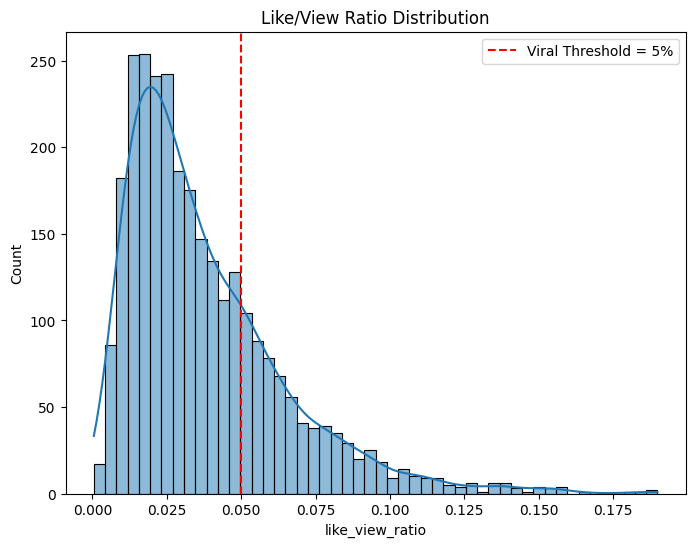

In [ ]:
sample_ratio = df.select("like_view_ratio", "is_viral").sample(fraction=0.001).toPandas()

plt.figure(figsize=(8,6))
sns.histplot(sample_ratio["like_view_ratio"], bins=50, kde=True)
plt.axvline(0.05, color="red", linestyle="--", label="Viral Threshold = 5%")
plt.title("Like/View Ratio Distribution")
plt.legend()
plt.show()


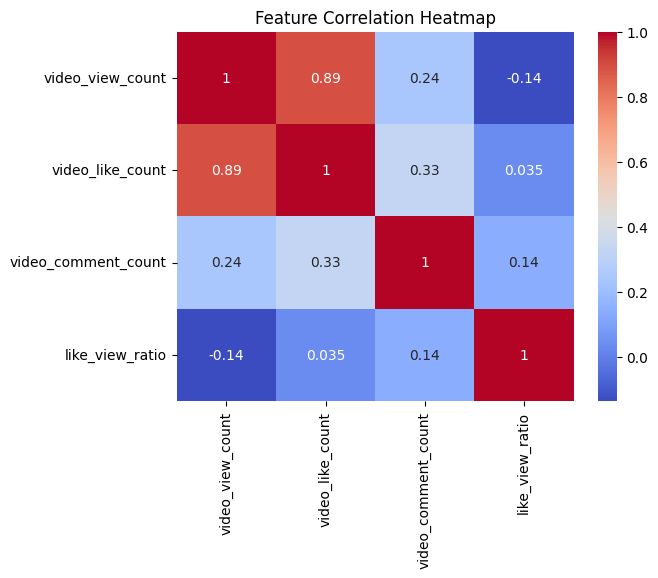

In [ ]:
numeric_df = df.select("video_view_count", "video_like_count", "video_comment_count", "like_view_ratio")
cor_pd = numeric_df.toPandas().corr()
sns.heatmap(cor_pd, annot=True, cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()

Feature Engineering and train a logistic regression model

In [ ]:
from pyspark.ml.feature import (
    Tokenizer, HashingTF, IDF, StringIndexer,
    CountVectorizer, VectorAssembler, StandardScaler
)
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# 1. Data clean
df = df.fillna({
    'video_title': '',
    'video_description': '',
    'video_tags': '',
    'video_trending_country': '',
    'video_view_count': 0,
    'video_like_count': 0,
    'video_comment_count': 0
})

# 2. Feature Engineering
# Title
title_tokenizer = Tokenizer(inputCol="video_title", outputCol="title_tokens")
title_hashingTF = HashingTF(inputCol="title_tokens", outputCol="title_tf", numFeatures=1000)
title_idf = IDF(inputCol="title_tf", outputCol="title_tfidf")

# Description
description_tokenizer = Tokenizer(inputCol="video_description", outputCol="description_tokens")
description_hashingTF = HashingTF(inputCol="description_tokens", outputCol="description_tf", numFeatures=1000)
description_idf = IDF(inputCol="description_tf", outputCol="description_tfidf")

# Tag
tags_tokenizer = Tokenizer(inputCol="video_tags", outputCol="tags_tokens")
tags_vectorizer = CountVectorizer(inputCol="tags_tokens", outputCol="tags_features")

# Country
country_indexer = StringIndexer(inputCol="video_trending_country", outputCol="country_index")

# numerical
numeric_cols = ["video_view_count", "video_like_count", "video_comment_count"]
numeric_assembler = VectorAssembler(inputCols=numeric_cols, outputCol="numeric_features")
scaler = StandardScaler(inputCol="numeric_features", outputCol="scaled_numeric_features")

# 3. Combine features
feature_cols = [
    "title_tfidf", "description_tfidf",
    "country_index", "tags_features",
    "scaled_numeric_features"
]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# 4. Define a model
lr = LogisticRegression(labelCol="is_viral", featuresCol="features")

# 5. Pipeline
pipeline = Pipeline(stages=[
    title_tokenizer, title_hashingTF, title_idf,
    description_tokenizer, description_hashingTF, description_idf,
    tags_tokenizer, tags_vectorizer,
    country_indexer,
    numeric_assembler, scaler,
    lr
])

# 6. Train and evaluate
model = pipeline.fit(df)


predictions = model.transform(df)


evaluator = BinaryClassificationEvaluator(labelCol="is_viral")
auc = evaluator.evaluate(predictions)
print(f"AUC: {auc}")

AUC: 0.9941089958148135


In [ ]:
import shutil

model_folder_path = '/content/lr_model'

shutil.make_archive('/content/lr_model', 'zip', model_folder_path)

from google.colab import files
files.download('/content/lr_model.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Model Visualization

             Feature  Coefficient  Importance (abs)
2      country_index     0.553944          0.553944
3      tags_features     0.548250          0.548250
1  description_tfidf     0.385117          0.385117
0        title_tfidf    -0.056106          0.056106


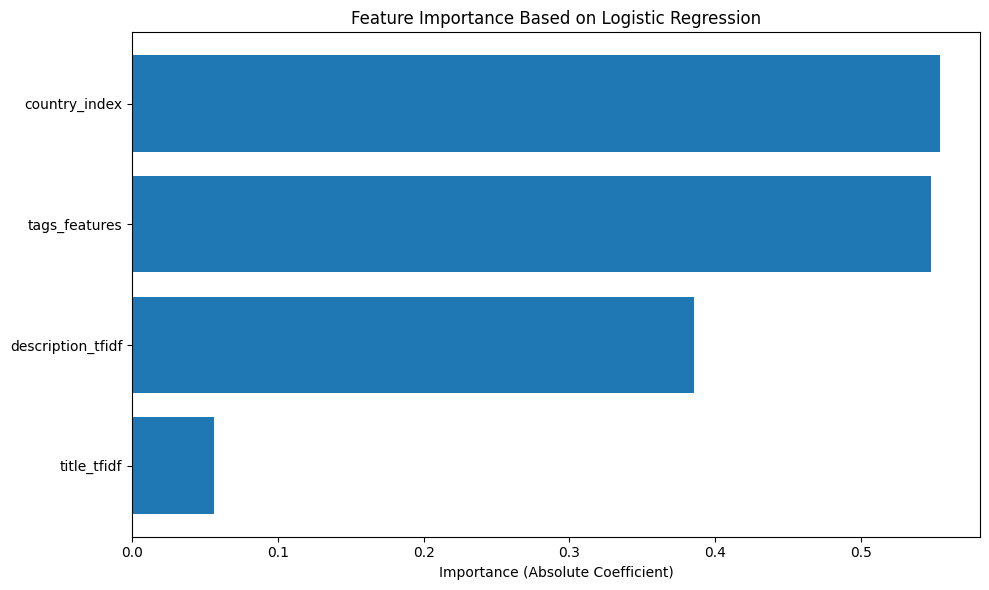

In [ ]:
lr_model = model.stages[-1]  # Last stage is the model



feature_names = ["title_tfidf", "description_tfidf", "country_index", "tags_features"]  # look at these four features

coefficients = lr_model.coefficients.toArray()  # obtain coeeficients in model


title_coeff = coefficients[0]
description_coeff = coefficients[1]
country_coeff = coefficients[2]
tags_coeff = coefficients[3]

# Calculate importance
import pandas as pd
import numpy as np

importance_data = {
    'Feature': ['title_tfidf', 'description_tfidf', 'country_index', 'tags_features'],
    'Coefficient': [np.mean(title_coeff), np.mean(description_coeff), np.mean(country_coeff), np.mean(tags_coeff)],
    'Importance (abs)': [np.mean(np.abs(title_coeff)), np.mean(np.abs(description_coeff)), np.mean(np.abs(country_coeff)), np.mean(np.abs(tags_coeff))]
}

importance_df = pd.DataFrame(importance_data)

importance_df = importance_df.sort_values(by='Importance (abs)', ascending=False)

print(importance_df)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance (abs)'])
plt.xlabel('Importance (Absolute Coefficient)')
plt.title('Feature Importance Based on Logistic Regression')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

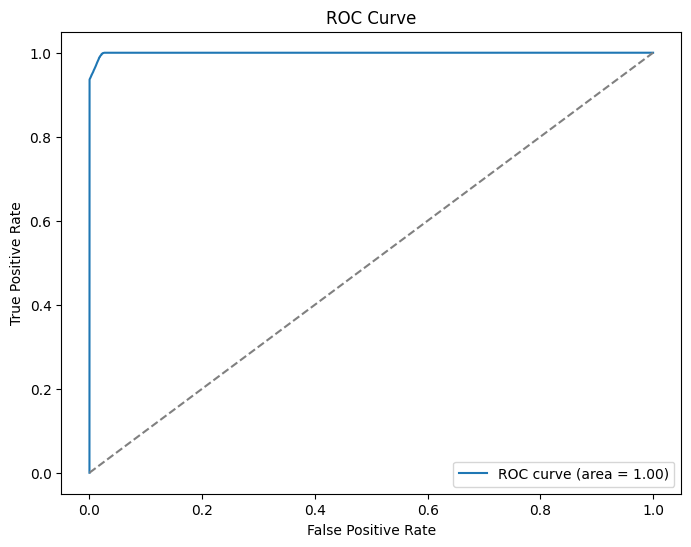

In [ ]:
from sklearn.metrics import roc_curve, auc

# Get raw prediction and label
roc_pd = predictions.select("is_viral", "probability").toPandas()
roc_pd["prob_1"] = roc_pd["probability"].apply(lambda x: x[1])

# ROC
fpr, tpr, thresholds = roc_curve(roc_pd["is_viral"], roc_pd["prob_1"])
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()
